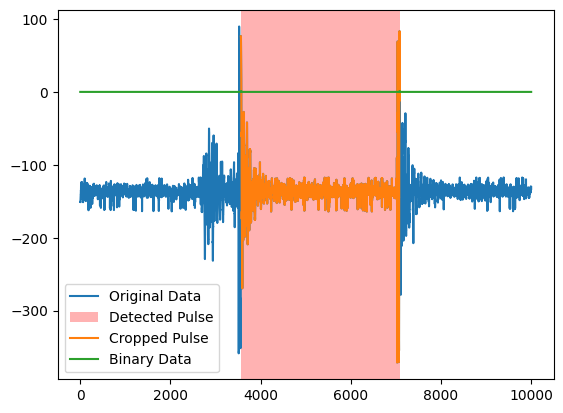

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 假设 data 是你采集到的离散数据
df = pd.read_csv('./output/20240102_210711.csv')
ACC_X = df['ACC_X']
ACC_Y = df['ACC_Y']
ACC_Z = df['ACC_Z']

# 滤波（这里使用简单的移动平均作为示例）
filtered_data = np.convolve(ACC_X, np.ones(10)/10, mode='same')

# 阈值处理
threshold = 0.5  # 根据实际情况调整阈值
binary_data = filtered_data > threshold

# 脉冲检测
pulse_start = np.argmax(binary_data)
pulse_end = len(binary_data) - np.argmax(binary_data[::-1])

# 裁剪
cropped_data = ACC_X[pulse_start:pulse_end]

# 绘制原始数据和裁剪后的数据
plt.plot(ACC_X, label='Original Data')
plt.axvspan(pulse_start, pulse_end, facecolor='red', alpha=0.3, label='Detected Pulse')
plt.plot(cropped_data, label='Cropped Pulse')
plt.plot(binary_data, label='Binary Data')
plt.legend()
plt.show()


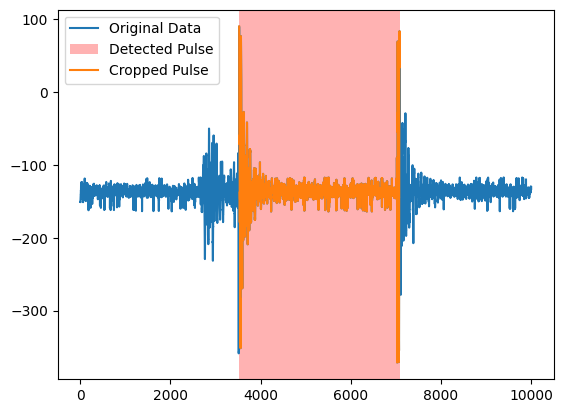

In [3]:
# 假设 data 是你采集到的离散数据
df = pd.read_csv('./output/20240102_210711.csv')
ACC_X = df['ACC_X']
ACC_Y = df['ACC_Y']
ACC_Z = df['ACC_Z']

# 滤波（这里使用简单的移动平均作为示例）
# filtered_data = np.convolve(ACC_X, np.ones(10)/10, mode='same')

# 阈值处理
threshold = 0.5  # 根据实际情况调整阈值
binary_data = ACC_X > threshold

# 脉冲检测
pulse_start = np.argmax(binary_data)
pulse_end = len(binary_data) - np.argmax(binary_data[::-1])

# 裁剪
cropped_data = ACC_X[pulse_start:pulse_end]

# 绘制原始数据和裁剪后的数据
plt.plot(ACC_X, label='Original Data')
plt.axvspan(pulse_start, pulse_end, facecolor='red', alpha=0.3, label='Detected Pulse')
plt.plot(cropped_data, label='Cropped Pulse')
plt.legend()
plt.show()